The Nasdaq Stock Market is the second-largest stock exchange in the world by market capitalization (USD 10 trillion). It has around 1000 listed companies with a Market Cap of atleast USD 1 billion. 

Of these companies can we find how the ones that will **outperform the broader market**?

In [2]:
import numpy as np 
import pandas as pd 
from os import listdir

import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Make the default figures a bit bigger
plt.rcParams['figure.figsize'] = (5,3) 
plt.rcParams["figure.dpi"] = 120 

sns.set(style="ticks")
sns.set_context("poster", font_scale = .6, rc={"grid.linewidth": 5})
greek_salad = ['#D0D3C5', '#56B1BF', '#08708A', '#D73A31', '#032B2F']
sns.set_palette(greek_salad)

# 1. Data extraction

## Get all tickers for NASDAQ will a market cap of atleast $10 billion

In [3]:
# https://www.nasdaq.com/screening/company-list.aspx
nasdaq = pd.read_csv('~/data/stock/nasdaq-company-list/companylist.csv')
cols = ['Symbol', 'Name', 'MarketCap', 'Sector']
nasdaq = nasdaq[cols]
nasdaq = nasdaq.drop_duplicates(subset=['Name'], keep='first')
nasdaq = nasdaq[nasdaq['MarketCap'] >= 1e9]
print(nasdaq.shape)
nasdaq.sort_values(by='MarketCap', ascending=False).head(10)

(888, 4)


,Symbol,Name,MarketCap,Sector
2068,MSFT,Microsoft Corporation,8.299033e+11,Technology
209,AAPL,Apple Inc.,8.059828e+11,Technology
150,AMZN,"Amazon.com, Inc.",7.994720e+11,Consumer Services
133,GOOG,Alphabet Inc.,7.776077e+11,Technology
1053,FB,"Facebook, Inc.",4.631740e+11,Technology
1616,INTC,Intel Corporation,2.311458e+11,Technology
659,CSCO,"Cisco Systems, Inc.",2.232245e+11,Technology
716,CMCSA,Comcast Corporation,1.699499e+11,Consumer Services
2451,PEP,"Pepsico, Inc.",1.628453e+11,Consumer Non-Durables
2205,NFLX,"Netflix, Inc.",1.580138e+11,Consumer Services


### Get filenames for all tickers

In [4]:
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

path_to_dir = '../input/amex-nyse-nasdaq-stock-histories/fh_20190217/full_history/'
filenames = find_csv_filenames(path_to_dir)

### Read data for all tickers into a dataframe

In [5]:
%%time 
# Create Empty Dataframe
stock_final = pd.DataFrame()

for i in range(len(list(nasdaq['Symbol']))): #filenames
    #print(i)    
    try:
        stock=[]
        stock = pd.read_csv(path_to_dir+list(nasdaq['Symbol'])[i]+'.csv')
        stock['name'] = list(nasdaq['Symbol'])[i] #filenames[i].replace(".csv", "")
        # Data starting from 2015
        stock['date'] = pd.to_datetime(stock['date'])
        stock = stock[stock.date >= '2016-01-01']
        stock_final = pd.DataFrame.append(stock_final, stock, sort=False)
    
    except Exception:
        i = i+1     

CPU times: user 18.9 s, sys: 7.22 s, total: 26.2 s
Wall time: 28.1 s


In [6]:
print("Available tickers", stock_final.name.nunique())
display(stock_final.sample(3))

Available tickers 888


,date,volume,open,close,high,low,adjclose,name
7,2019-02-06,1207300,62.240002,64.400002,65.449997,61.599998,64.400002,ALRM
128,2018-08-13,2239200,223.970001,215.789993,224.649994,213.589996,214.753357,NTES
641,2016-07-29,1492500,54.810001,54.820000,55.380001,54.279999,50.610302,CONE


## Extract relevant data

Will be working with only **Adjusted Close** and **Volume**

In [7]:
cols = ['date', 'adjclose', 'name']
df_close = stock_final[cols].pivot(index='date', columns='name', values='adjclose')

cols = ['date', 'volume', 'name']
df_volume = stock_final[cols].pivot(index='date', columns='name', values='volume')

print('Dataset shape:',df_close.shape)
display(df_close.tail(3))

print('Dataset shape:',df_volume.shape)
display(df_volume.tail(3))

Dataset shape: (786, 888)


name,AABA,AAL,AAON,AAPL,AAWW,AAXJ,AAXN,ABCB,ABMD,ACAD,ACGL,ACHC,ACIA,ACIW,ACWI,ACWX,ADBE,ADI,ADP,ADSK,AEIS,AERI,AFIN,AGIO,AGNC,AIA,AIMC,AIMT,AINV,AKAM,AKCA,ALEC,ALGN,ALGT,ALKS,ALLK,ALLO,ALNY,ALRM,ALTM,...,WB,WBA,WDAY,WDC,WDFC,WEN,WERN,WETF,WIFI,WING,WIRE,WIX,WLTW,WMGI,WRLD,WSBC,WSC,WSFS,WTFC,WTW,WVE,WWD,WYNN,XEL,XENT,XLNX,XLRN,XNCR,XON,XPER,XRAY,XT,YNDX,YY,Z,ZBRA,ZGNX,ZION,ZNGA,ZS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-13,69.070000,36.209999,39.130001,170.179993,53.799999,68.599998,53.700001,38.980000,361.500000,22.309999,31.959999,27.129999,43.689999,30.219999,69.830002,44.889999,260.230011,104.419998,150.460007,160.029999,50.459999,41.549999,11.30,54.029999,17.730000,60.250000,31.190001,23.809999,15.34,70.370003,26.490000,NaN,251.850006,138.149994,32.919998,34.770000,31.940001,84.389999,64.739998,7.99,...,66.169998,71.989998,187.750000,47.689999,174.119995,17.700001,34.970001,6.29,24.260000,68.309998,54.509998,119.410004,170.970001,30.959999,114.830002,41.029999,10.28,42.090000,72.930000,29.990000,36.730000,93.995338,126.800003,53.270000,32.470001,117.389999,42.389999,35.750000,7.69,22.559999,43.869999,36.740002,33.860001,69.820000,35.790001,183.970001,47.720001,49.549999,4.90,49.000000
2019-02-14,68.620003,36.110001,38.459999,170.800003,54.279999,68.589996,54.590000,38.290001,357.820007,21.930000,31.120001,27.180000,44.430000,30.200001,69.790001,44.939999,260.140015,104.489998,148.149994,159.940002,50.720001,41.070000,11.16,57.419998,17.690001,60.250000,30.889999,23.580000,15.31,70.779999,26.879999,NaN,250.750000,139.740005,32.500000,35.259998,31.139999,83.029999,65.010002,7.87,...,65.529999,72.110001,188.539993,47.980000,172.360001,17.900000,35.060001,6.54,24.790001,68.629997,54.209999,119.660004,168.500000,31.350000,113.790001,40.400002,10.21,41.400002,72.709999,29.879999,36.529999,93.046997,123.430000,53.270000,32.450001,117.519997,41.770000,35.070000,7.58,22.850000,43.680000,36.730000,34.410000,68.870003,35.970001,196.470001,47.060001,48.930000,4.98,50.080002
2019-02-15,67.860001,35.049999,39.459999,170.419998,54.230000,68.260002,55.430000,39.689999,362.059998,23.250000,31.500000,28.410000,44.660000,30.750000,70.510002,45.410000,259.450012,105.739998,149.669998,160.350006,51.160000,41.750000,11.03,59.290001,17.620001,59.889999,32.029999,24.209999,15.32,70.089996,27.690001,19.780001,254.960007,139.210007,32.540001,34.849998,31.240000,83.529999,65.010002,8.14,...,64.279999,73.430000,190.789993,47.650002,173.449997,18.000000,34.459999,6.92,25.530001,68.320000,54.810001,121.400002,169.559998,31.870001,117.449997,41.470001,10.29,42.770000,74.290001,30.280001,37.599998,95.099998,124.510002,53.459999,33.340000,119.309998,42.459999,36.459999,8.04,22.790001,43.580002,37.070000,31.469999,68.760002,37.180000,199.750000,46.990002,50.110001,5.03,50.110001


Dataset shape: (786, 888)


name,AABA,AAL,AAON,AAPL,AAWW,AAXJ,AAXN,ABCB,ABMD,ACAD,ACGL,ACHC,ACIA,ACIW,ACWI,ACWX,ADBE,ADI,ADP,ADSK,AEIS,AERI,AFIN,AGIO,AGNC,AIA,AIMC,AIMT,AINV,AKAM,AKCA,ALEC,ALGN,ALGT,ALKS,ALLK,ALLO,ALNY,ALRM,ALTM,...,WB,WBA,WDAY,WDC,WDFC,WEN,WERN,WETF,WIFI,WING,WIRE,WIX,WLTW,WMGI,WRLD,WSBC,WSC,WSFS,WTFC,WTW,WVE,WWD,WYNN,XEL,XENT,XLNX,XLRN,XNCR,XON,XPER,XRAY,XT,YNDX,YY,Z,ZBRA,ZGNX,ZION,ZNGA,ZS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-13,3367400.0,5837900.0,161400.0,22490200.0,166800.0,560200.0,310600.0,214500.0,300100.0,727500.0,1898900.0,998100.0,467900.0,843800.0,2355700.0,1467800.0,1899700.0,2417100.0,2136700.0,1898000.0,294900.0,1028500.0,584500.0,430100.0,5883900.0,46700.0,479000.0,702700.0,224700.0,4038100.0,171500.0,NaN,1137700.0,112400.0,770100.0,302900.0,308300.0,694300.0,246500.0,240500.0,...,3419400.0,3856900.0,1664800.0,6110200.0,152300.0,2343900.0,609800.0,1519900.0,186600.0,761700.0,80600.0,910900.0,562500.0,4684400.0,79600.0,82500.0,934800.0,122800.0,153000.0,2011000.0,183800.0,444900.0,1099800.0,2533600.0,338700.0,3758900.0,279600.0,65400.0,802300.0,771400.0,1980100.0,69300.0,3989800.0,1149600.0,1358100.0,610300.0,447900.0,2270100.0,17119800.0,1194800.0
2019-02-14,5647100.0,4070000.0,159600.0,21835700.0,257800.0,754000.0,305200.0,297200.0,254500.0,1372100.0,1641100.0,867200.0,535900.0,809800.0,5637300.0,4586700.0,1885000.0,2971500.0,2656900.0,1470400.0,182300.0,272000.0,1548200.0,862200.0,5066800.0,50900.0,254300.0,909200.0,356700.0,1409200.0,106900.0,NaN,1120700.0,154000.0,1164600.0,194400.0,247600.0,398000.0,283800.0,184900.0,...,1833300.0,3855100.0,1425800.0,5293600.0,119700.0,2844200.0,621400.0,1698800.0,171400.0,388600.0,97900.0,502500.0,878100.0,1854700.0,85300.0,207800.0,400000.0,220100.0,403200.0,1462400.0,111200.0,348900.0,2837900.0,6425400.0,221200.0,2666100.0,304500.0,125500.0,1026600.0,459300.0,1143300.0,117800.0,4603600.0,1006600.0,1980200.0,2749500.0,319900.0,2709100.0,14288200.0,1315000.0
2019-02-15,8524900.0,11426000.0,115600.0,24363100.0,346200.0,527500.0,415200.0,676900.0,311200.0,1792300.0,2055700.0,909200.0,505800.0,629000.0,2482800.0,1319000.0,2994800.0,2157200.0,2859100.0,1693100.0,188600.0,856100.0,707300.0,756200.0,6371000.0,23800.0,411200.0,794000.0,264100.0,1398600.0,153300.0,408850.0,839900.0,101100.0,949300.0,232000.0,331000.0,531400.0,285600.0,292900.0,...,1591500.0,4658200.0,1710500.0,4431500.0,129700.0,5715000.0,749900.0,3265400.0,414000.0,341200.0,66500.0,563300.0,950300.0,2071000.0,120000.0,129100.0,296600.0,179200.0,202500.0,2426900.0,196000.0,348300.0,2477900.0,2858700.0,295200.0,3005500.0,492300.0,144300.0,1125700.0,488100.0,1833900.0,81300.0,6789100.0,547500.0,3177800.0,766200.0,355300.0,2741800.0,25918900.0,1007900.0


## Missing data

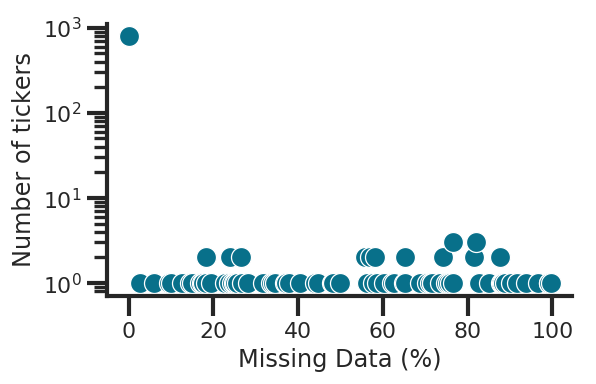

In [8]:
percent_missing = pd.DataFrame(df_close.isnull().sum() * 100 / len(df_close))
percent_missing.columns = ['percent_missing']
percent_missing.sort_values('percent_missing', inplace=True, ascending=False)

percent_missing_plot = pd.DataFrame(percent_missing.reset_index().groupby('percent_missing').size())
percent_missing_plot.reset_index(inplace=True)
percent_missing_plot.columns = ['percent_missing', 'count']

ax = sns.scatterplot(x='percent_missing', y='count', data=percent_missing_plot, color=greek_salad[2])
ax.set_yscale('log')
ax.set_ylabel('Number of tickers')
ax.set_xlabel('Missing Data (%)')
sns.despine()

## Remove columns with any missing data

In [9]:
complete_data_tickers = percent_missing[percent_missing['percent_missing'] == 0].index
df = df_close[complete_data_tickers].head()

print("Available tickers", df.shape[1])
display(df.sample(3))

Available tickers 797


name,UTHR,PDCO,PBCT,PBYI,PCAR,XEL,PCH,PCRX,PCTY,PDBC,PDCE,WYNN,PATK,PDP,PEGA,PEGI,PENN,PEP,WWD,WVE,PFF,PFG,PAYX,PAHC,PGTI,PACW,ODP,OFIX,XENT,OLED,OLLI,OMCL,ON,ONB,ONCE,ONEQ,OPK,ORBK,ORLY,OSIS,...,HDS,HFWA,GRMN,HMHC,HMSY,HOLI,HOLX,HOMB,HOPE,HPT,HQY,HRTX,HSIC,GRPN,GRFS,FSLR,GBDC,FSV,FTA,FTCS,FTNT,FTSL,FTSM,FULT,FV,FWRD,GBCI,GBT,GPOR,GGAL,GHDX,GIII,GILD,GLNG,GLPI,GLUU,GNTX,GOLD,GOOG,LHCG
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,155.539993,39.284889,13.830870,73.540001,42.047928,32.395283,24.231365,75.629997,38.560001,13.782636,54.209999,64.482521,27.766666,39.959488,26.825523,15.934107,14.697140,90.338760,48.487808,15.07,32.777889,39.792408,46.382236,28.084984,11.18,36.230827,5.073619,38.500000,21.190001,53.258881,17.33,29.10,9.70,11.927096,41.849998,186.505646,10.00,21.850000,246.110001,86.279999,...,30.480000,17.061604,31.479355,20.469999,12.71,21.211300,37.830002,18.199087,15.210186,20.554857,24.969999,25.059999,60.886276,3.00,15.018680,66.720001,13.341551,38.521126,36.368935,36.258556,30.230000,41.914265,57.066864,11.651896,22.662615,41.364498,22.953661,29.209999,24.799999,25.844557,33.610001,45.080002,90.219879,16.480812,22.133680,2.42,14.756063,48.786312,741.840027,42.970001
2016-01-08,141.500000,38.394646,13.111698,59.009998,40.327145,32.830849,22.458742,67.559998,36.590000,13.318455,52.130001,54.140198,25.026667,38.231567,24.684238,15.101670,14.111114,88.911926,44.921387,13.20,32.618336,36.268562,42.792210,28.123459,9.67,33.179359,4.944237,38.080002,19.200001,50.059162,18.16,27.48,8.53,11.318941,34.290001,176.719711,8.82,20.790001,234.660004,82.180000,...,27.209999,16.903627,28.699251,18.360001,12.03,17.211008,36.549999,18.222448,14.204028,19.683025,22.540001,23.620001,58.933334,2.78,14.482968,65.620003,13.087728,35.106995,34.388115,34.907787,28.610001,41.905354,57.085930,11.201625,21.538361,41.306480,21.653233,23.400000,23.959999,24.403812,31.660000,43.380001,88.783867,15.360850,21.420982,2.41,13.235742,49.801388,714.469971,42.240002
2016-01-06,147.119995,39.997803,13.690542,67.089996,42.065765,33.066780,23.992270,75.120003,36.680000,13.407721,52.029999,62.297787,26.866667,39.623779,26.676823,15.839870,14.539005,90.988167,47.610825,14.17,32.735905,38.238297,45.689423,28.748634,10.45,35.947174,5.276935,40.000000,20.969999,51.634106,18.60,28.32,9.19,11.863558,37.180000,184.439835,9.14,21.950001,241.070007,87.820000,...,28.420000,17.340391,30.735138,19.760000,12.62,18.489153,38.419998,18.409348,15.056087,20.224976,23.320000,27.480000,60.474510,3.03,15.140859,69.519997,13.420870,35.350868,35.597553,36.113831,29.500000,41.914265,57.066864,11.716222,22.435793,42.060669,22.810757,23.930000,22.590000,25.242603,34.009998,44.650002,92.327873,15.457401,22.181734,2.34,13.772326,49.254810,743.619995,44.099998


## This is the final dataset we will be working with: Daily percentage change in **price** and **volume**

In [10]:
df_pct_change = df.pct_change()
df_pct_change.head(3)

name,UTHR,PDCO,PBCT,PBYI,PCAR,XEL,PCH,PCRX,PCTY,PDBC,PDCE,WYNN,PATK,PDP,PEGA,PEGI,PENN,PEP,WWD,WVE,PFF,PFG,PAYX,PAHC,PGTI,PACW,ODP,OFIX,XENT,OLED,OLLI,OMCL,ON,ONB,ONCE,ONEQ,OPK,ORBK,ORLY,OSIS,...,HDS,HFWA,GRMN,HMHC,HMSY,HOLI,HOLX,HOMB,HOPE,HPT,HQY,HRTX,HSIC,GRPN,GRFS,FSLR,GBDC,FSV,FTA,FTCS,FTNT,FTSL,FTSM,FULT,FV,FWRD,GBCI,GBT,GPOR,GGAL,GHDX,GIII,GILD,GLNG,GLPI,GLUU,GNTX,GOLD,GOOG,LHCG
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,-0.035361,0.013306,-0.000634,-0.048409,0.000212,0.010084,0.011228,-0.015338,-0.040197,-0.009067,-0.007932,0.018904,-0.040336,0.002965,0.004804,-0.009857,0.007595,0.006885,0.009446,-0.032515,0.001025,0.002271,-0.000776,0.018151,-0.016995,-0.004033,0.052824,0.024156,0.010854,-0.012353,0.037507,-0.015808,-0.002062,0.003044,-0.033811,-0.001508,-0.018000,0.005492,0.007517,0.013792,...,-0.039042,0.017429,0.003804,-0.017587,0.002360,-0.084177,0.002379,0.007959,0.001192,0.003821,-0.040048,0.100559,0.003414,0.043333,-0.008135,0.079586,-0.004162,-0.055964,-0.000524,0.006919,-0.012901,-0.000851,0.0,0.004732,0.002176,0.018934,0.007004,-0.069497,-0.029435,-0.003436,0.011901,0.000887,0.012754,-0.021090,0.018452,-0.012397,-0.027751,0.00160,0.000998,-0.009542
2016-01-06,-0.019461,0.004778,-0.009518,-0.041298,0.000212,0.010538,-0.020861,0.008728,-0.008916,-0.018301,-0.032540,-0.051805,0.008256,-0.011333,-0.010298,0.003982,-0.018216,0.000302,-0.027275,-0.028121,-0.002303,-0.041233,-0.014172,0.005382,-0.049136,-0.003811,-0.012111,0.014456,-0.021008,-0.018382,0.034483,-0.011173,-0.050620,-0.008346,-0.080500,-0.009583,-0.069246,-0.000910,-0.027787,0.004001,...,-0.029703,-0.001071,-0.027342,-0.017404,-0.009419,-0.048217,0.013186,0.003566,-0.011310,-0.019794,-0.027117,-0.003626,-0.010142,-0.031949,0.016404,-0.034847,0.010149,-0.027897,-0.020697,-0.010835,-0.011394,0.000852,0.0,0.000785,-0.012158,-0.002065,-0.013137,-0.119573,-0.061487,-0.019923,0.000000,-0.010417,0.010478,-0.041891,-0.015986,-0.020921,-0.040026,0.00799,0.001400,0.036184


In [11]:
complete_data_tickers = percent_missing[percent_missing['percent_missing'] == 0].index
df_volume = df_volume[complete_data_tickers].head()

df_vol_change = df_volume.pct_change()
df_vol_change.head(3)

name,UTHR,PDCO,PBCT,PBYI,PCAR,XEL,PCH,PCRX,PCTY,PDBC,PDCE,WYNN,PATK,PDP,PEGA,PEGI,PENN,PEP,WWD,WVE,PFF,PFG,PAYX,PAHC,PGTI,PACW,ODP,OFIX,XENT,OLED,OLLI,OMCL,ON,ONB,ONCE,ONEQ,OPK,ORBK,ORLY,OSIS,...,HDS,HFWA,GRMN,HMHC,HMSY,HOLI,HOLX,HOMB,HOPE,HPT,HQY,HRTX,HSIC,GRPN,GRFS,FSLR,GBDC,FSV,FTA,FTCS,FTNT,FTSL,FTSM,FULT,FV,FWRD,GBCI,GBT,GPOR,GGAL,GHDX,GIII,GILD,GLNG,GLPI,GLUU,GNTX,GOLD,GOOG,LHCG
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,0.059814,-0.454723,-0.210167,0.129942,-0.250851,-0.240521,-0.354686,-0.221868,0.253092,-0.114019,-0.272055,0.008542,0.191186,-0.658151,-0.137182,-0.216643,-0.388287,-0.268381,-0.183950,-0.393939,-0.151554,-0.181203,-0.030836,-0.247492,-0.446398,0.09173,1.867589,0.255932,-0.48174,-0.253355,0.196641,-0.397857,0.423593,-0.222681,-0.492155,-0.380741,0.037322,-0.043744,-0.311046,-0.297666,...,-0.183796,-0.463891,-0.363202,-0.498613,-0.411820,-0.033651,0.369629,-0.118343,-0.339194,-0.232562,-0.365265,-0.286891,-0.370024,0.071794,0.073291,2.002210,0.315408,-0.316667,0.324900,-0.386609,-0.441238,-0.698690,-0.883163,-0.244401,-0.358277,-0.058091,-0.263247,1.199201,-0.495870,-0.067610,-0.434488,-0.006345,-0.378653,-0.287038,0.067771,-0.391240,0.345207,-0.541380,-0.403966,0.174292
2016-01-06,0.152606,0.780365,0.012243,0.352472,0.324601,1.424762,0.036186,0.219494,-0.285088,-0.116034,1.033622,-0.226313,-0.536217,-0.302638,-0.126874,-0.270966,1.081182,0.120479,0.612567,-0.087500,-0.089344,0.419138,-0.136469,0.932444,1.059776,0.15065,-0.103441,0.275978,0.43076,0.317810,0.419298,0.778528,0.233858,0.569510,0.649695,-0.076555,1.244755,0.234397,0.182072,1.117241,...,-0.080652,0.099515,0.931367,0.162009,0.206539,1.017025,0.516397,0.000000,-0.045671,0.176316,0.433538,0.095408,0.190074,0.023803,0.074776,-0.538463,-0.100629,-0.409756,0.120603,0.084507,0.718163,-0.346509,-0.760057,0.317803,-0.080793,0.472100,-0.035324,-0.053348,0.535148,-0.027544,1.570707,0.504470,0.354170,0.012540,-0.161468,-0.039447,0.358433,0.990916,-0.001897,0.144712


# 2. Correlation of percent change

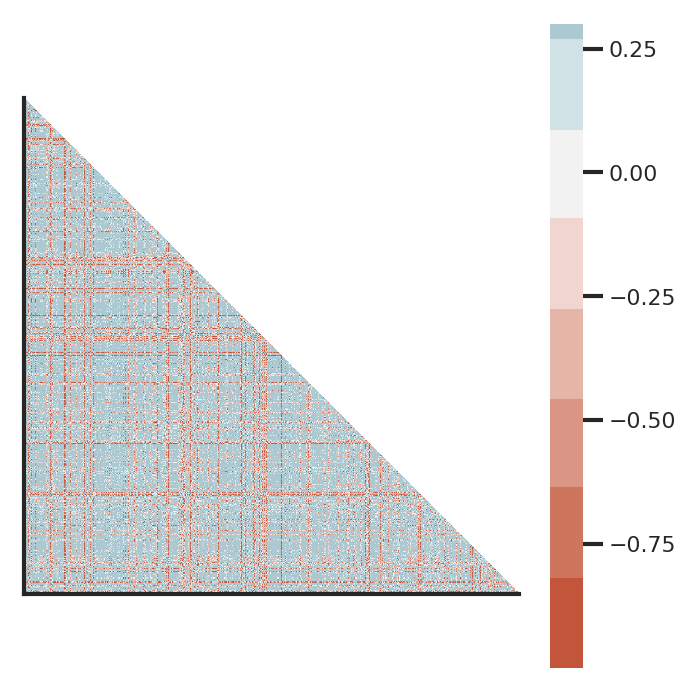

In [12]:
plt.figure(figsize=(6,6))
corr = df_pct_change.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap=sns.diverging_palette(20,220, n=11), center=0)
    ax.set_yticklabels('')
    ax.set_xticklabels('')
    ax.set_ylabel('')
    ax.set_xlabel('')
    sns.despine()
    plt.tight_layout()

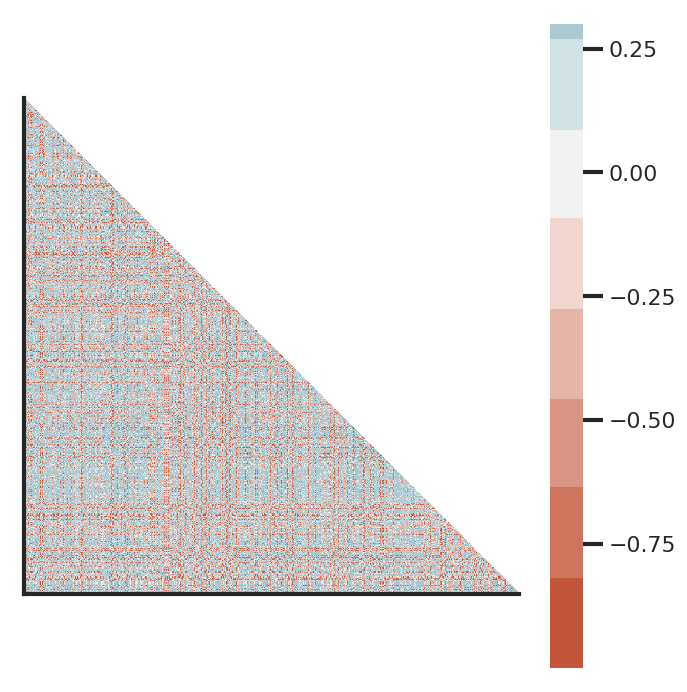

In [13]:
plt.figure(figsize=(6,6))
corr = df_vol_change.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap=sns.diverging_palette(20,220, n=11), center=0)
    ax.set_yticklabels('')
    ax.set_xticklabels('')
    ax.set_ylabel('')
    ax.set_xlabel('')
    sns.despine()
    plt.tight_layout()

# 3. How good a bet is Microsoft? **`MSFT`**

In [14]:
MSFT = stock_final[stock_final.name == 'MSFT'].copy()
MSFT.set_index('date', inplace=True)
MSFT.head()

,volume,open,close,high,low,adjclose,name
date,,,,,,,
2019-02-15,26537100,107.910004,108.220001,108.300003,107.360001,108.220001,MSFT
2019-02-14,21784700,106.309998,106.900002,107.290001,105.660004,106.900002,MSFT
2019-02-13,18394900,107.500000,106.809998,107.779999,106.709999,106.809998,MSFT
2019-02-12,25056600,106.139999,106.889999,107.139999,105.480003,106.889999,MSFT
2019-02-11,18914100,106.199997,105.250000,106.580002,104.970001,105.250000,MSFT


In [15]:
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

trace = go.Ohlc(x=MSFT.index,
                open=MSFT['open'],
                high=MSFT['high'],
                low=MSFT['low'],
                close=MSFT['close'],
               increasing=dict(line=dict(color= '#58FA58')),
                decreasing=dict(line=dict(color= '#FA5858')))

layout = {
    'title': 'MSFT Historical Price',
    'xaxis': {'title': 'Date',
             'rangeslider': {'visible': False}},
    'yaxis': {'title': 'Stock Price (USD$)'},
    'shapes': [{
        'x0': '2018-12-31', 'x1': '2018-12-31',
        'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
        'line': {'color': 'rgb(30,30,30)', 'width': 1}
    }],
    'annotations': [{
        'x': '2019-01-01', 'y': 0.05, 'xref': 'x', 'yref': 'paper',
        'showarrow': False, 'xanchor': 'left',
        'text': '2019 <br> starts'
    }]
}

data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple_ohlc')

## Forecast stock price

In [16]:
# Drop the columns
ph_df = MSFT.drop(['open', 'high', 'low','volume', 'adjclose', 'name'], axis=1)
ph_df.reset_index(inplace=True)
ph_df.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)
ph_df['ds'] = pd.to_datetime(ph_df['ds'])
ph_df['y'] = np.log1p(ph_df['y'])
ph_df.head()

,ds,y
0,2019-02-15,4.693364
1,2019-02-14,4.681205
2,2019-02-13,4.680370
3,2019-02-12,4.681112
4,2019-02-11,4.665795


In [17]:
!pip3 uninstall --yes fbprophet
!pip3 install fbprophet --no-cache-dir --no-binary :all:

Uninstalling fbprophet-0.3.post2:
  Successfully uninstalled fbprophet-0.3.post2
    100% |████████████████████████████████| 51kB 2.6MB/s 
    100% |████████████████████████████████| 71kB 7.3MB/s 
    100% |████████████████████████████████| 747kB 56.0MB/s 
  Running setup.py install for lunardate ... - done
  Running setup.py install for ephem ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Running setup.py install for convertdate ... - done
  Running setup.py install for holidays ... - done
  Running setup.py install for setuptools-git ... - done
  Running setup.py install for fbprophet ... - \ | done
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [18]:
from fbprophet import Prophet
m = Prophet()
m.fit(ph_df) 

# Create Future dates
future_prices = m.make_future_dataframe(periods=365)

# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1146,2020-02-11,4.831817,4.016757,5.641651
1147,2020-02-12,4.832162,4.017530,5.646423
1148,2020-02-13,4.831980,3.998158,5.639609
1149,2020-02-14,4.833787,4.012410,5.654583
1150,2020-02-15,4.818003,3.985912,5.641306


## Daily predictions

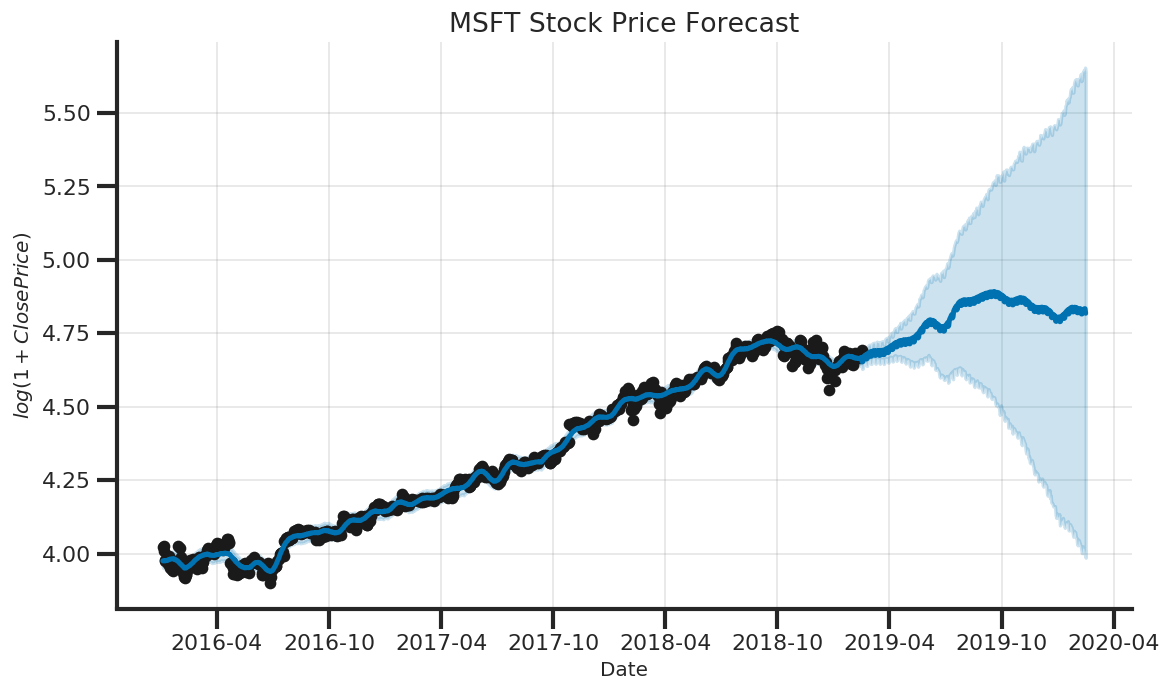

In [19]:
fig = m.plot(forecast)
ax1 = fig.add_subplot(111)
ax1.set_title("MSFT Stock Price Forecast", fontsize=16)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("$log(1 + Close Price)$", fontsize=12)
sns.despine()
plt.tight_layout()

In [20]:
# fig2 = m.plot_components(forecast)
# plt.show()

## Monthly predictions

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


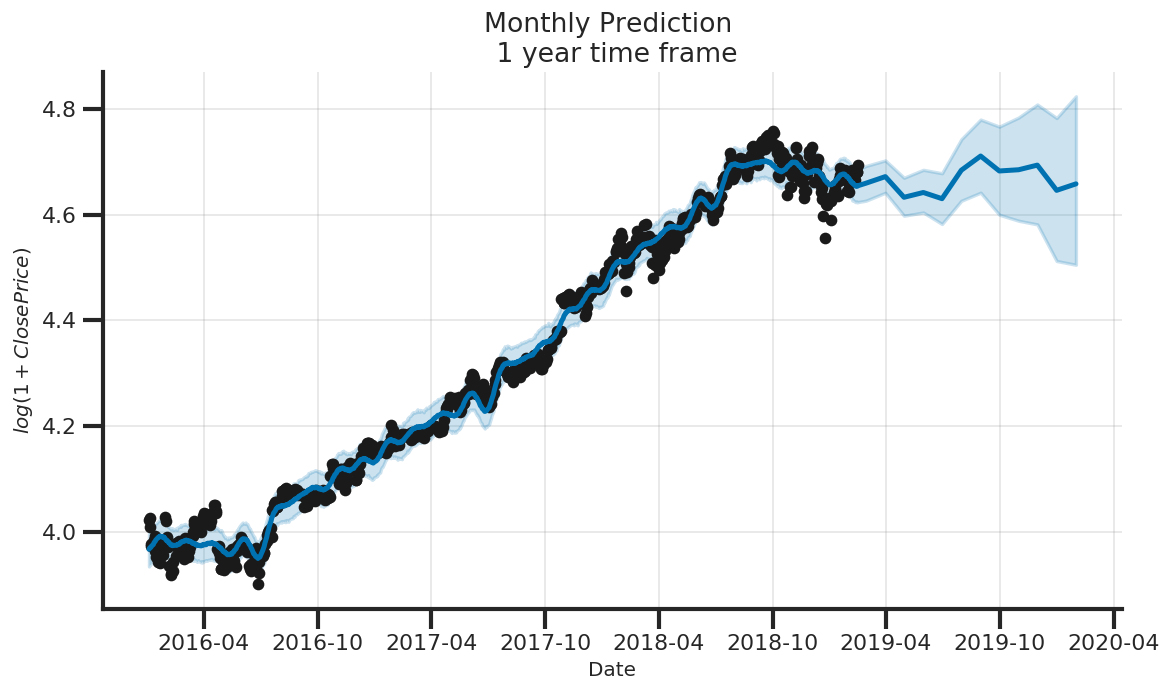

In [21]:
# Monthly Data Predictions
m = Prophet(changepoint_prior_scale=0.01).fit(ph_df)
future = m.make_future_dataframe(periods=12, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)
plt.title("Monthly Prediction \n 1 year time frame", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("$log(1+Close Price)$", fontsize=12)
sns.despine()
plt.tight_layout()

In [22]:
stock_max = np.round(np.expm1(fcst.tail(12)['yhat'].max()), 2)
stock_min = np.round(np.expm1(fcst.tail(12)['yhat'].min()), 2)
stock_current = np.expm1(ph_df.sort_values(by='ds').tail(1)['y'].values)

gain = (stock_max - stock_current) / stock_current
loss = (stock_current - stock_min) / stock_current

print('Current price:', np.round(stock_current,2), '$')
print('Expected High:', np.round(stock_max,2), '$')
print('Expected Low:', np.round(stock_min,2), '$')
print('Expected profit:', np.round(gain*100,2), '%')
print('Expected loss:', np.round(loss*100,2), '%')

Current price: [108.22] $
Expected High: 110.13 $
Expected Low: 101.52 $
Expected profit: [1.76] %
Expected loss: [6.19] %


# 4. Forecasting Dow Jones Industrial Average

Can we find a ticker which will outperform the benchmark?

In [23]:
!pip3 install fix_yahoo_finance --upgrade --no-cache-dir

  Running setup.py install for multitasking ... - done
  Running setup.py install for fix-yahoo-finance ... - done
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [24]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
from datetime import date

yf.pdr_override() 

end = date.today()
DJI = pdr.get_data_yahoo("^DJI", start="2016-01-01", end=end)

[*********************100%***********************]  1 of 1 downloaded


In [25]:
DJI.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-20,25872.259766,25986.199219,25846.480469,25954.439453,25954.439453,287880000
2019-02-21,25922.410156,25938.880859,25762.210938,25850.630859,25850.630859,255710000
2019-02-22,25906.269531,26052.900391,25906.269531,26031.810547,26031.810547,279760000
2019-02-25,26126.150391,26241.419922,26080.660156,26091.949219,26091.949219,281600000
2019-02-26,26051.609375,26155.289063,25966.009766,26057.980469,26057.980469,257850000


In [26]:
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

trace = go.Ohlc(x=DJI.index,
                open=DJI['Open'],
                high=DJI['High'],
                low=DJI['Low'],
                close=DJI['Close'],
               increasing=dict(line=dict(color= '#58FA58')),
                decreasing=dict(line=dict(color= '#FA5858')))

layout = {
    'title': 'DJI Historical Price',
    'xaxis': {'title': 'Date',
             'rangeslider': {'visible': False}},
    'yaxis': {'title': 'Stock Price (USD$)'},
    'shapes': [{
        'x0': '2018-12-31', 'x1': '2018-12-31',
        'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
        'line': {'color': 'rgb(30,30,30)', 'width': 1}
    }],
    'annotations': [{
        'x': '2019-01-01', 'y': 0.05, 'xref': 'x', 'yref': 'paper',
        'showarrow': False, 'xanchor': 'left',
        'text': '2019 <br> starts'
    }]
}

data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple_ohlc')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


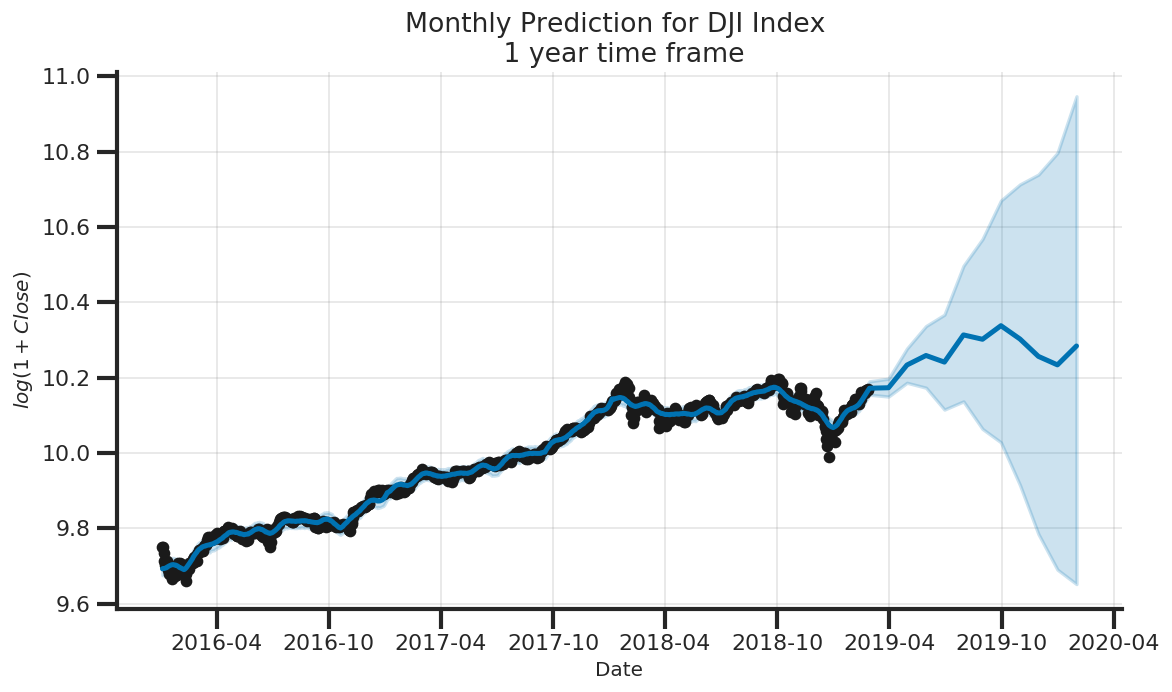

In [27]:
# Drop the columns
ph_df = DJI.drop(['Open', 'High', 'Low','Volume', 'Adj Close'], axis=1)
ph_df.reset_index(inplace=True)
ph_df.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)
ph_df['ds'] = pd.to_datetime(ph_df['ds'])
ph_df['y'] = np.log1p(ph_df['y'])
ph_df.head()

# Monthly Data Predictions
m = Prophet(changepoint_prior_scale=0.01).fit(ph_df)
future = m.make_future_dataframe(periods=12, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)
plt.title("Monthly Prediction for DJI Index \n 1 year time frame", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("$log(1+Close)$", fontsize=12)
sns.despine()
plt.tight_layout()

In [28]:
stock_max = np.round(np.expm1(fcst.tail(12)['yhat'].max()), 2)
stock_min = np.round(np.expm1(fcst.tail(12)['yhat'].min()), 2)
stock_current = np.expm1(ph_df.sort_values(by='ds').tail(1)['y'].values)

DJI_gain = (stock_max - stock_current) / stock_current
DJI_loss = (stock_current - stock_min) / stock_current

print('Current :', np.round(stock_current,2))
print('Expected High:', np.round(stock_max,2))
print('Expected Low:', np.round(stock_min,2))
print('Expected rise:', np.round(DJI_gain*100,2), '%')
print('Expected fall:', np.round(DJI_loss*100,2), '%')

Current : [26057.98]
Expected High: 30878.56
Expected Low: 26155.6
Expected rise: [18.5] %
Expected fall: [-0.37] %


# 5. Predicting expected gain and loss for each ticker

In [29]:
%%time
df_gains = pd.DataFrame()
i = 0
for ticker in df_close.columns:
    tmp = pd.DataFrame()
    ticker = df_close.columns[i]
    ph_df = pd.DataFrame(df_close[ticker].copy())
    ph_df.reset_index(inplace=True)
    ph_df.rename(columns={ticker: 'y', 'date': 'ds'}, inplace=True)
    ph_df['ds'] = pd.to_datetime(ph_df['ds'])
    ph_df['y'] = np.log1p(ph_df['y'])

    m = Prophet(changepoint_prior_scale=0.01).fit(ph_df)
    future = m.make_future_dataframe(periods=12, freq='M')
    fcst = m.predict(future)
    
    stock_max = np.round(np.expm1(fcst.tail(12)['yhat'].max()), 2)
    stock_min = np.round(np.expm1(fcst.tail(12)['yhat'].min()), 2)
    stock_current = np.expm1(ph_df.sort_values(by='ds').tail(1)['y'].values)

    gain = (stock_max - stock_current) / stock_current
    loss = (stock_current - stock_min) / stock_current
    tmp = pd.DataFrame([ticker, gain, loss]).T
    t = [('ticker', ticker),
         ('gain', gain),
         ('loss', loss)]
    tmp = pd.DataFrame.from_items(t)
    df_gains = df_gains.append(tmp)
    i = i+1
    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

CPU times: user 1h 32min 25s, sys: 1h 31min 48s, total: 3h 4min 14s
Wall time: 1h 22s


# Tickers that may beat the benchmark

In [30]:
df_gains = df_gains.loc[(df_gains['gain'] >= DJI_gain[0])]
df_gains = df_gains.loc[(df_gains['loss'] <= DJI_loss[0])]
df_gains.sample(5)

,ticker,gain,loss
0,MNRO,0.449553,-0.037689
0,ALEC,42.914559,-0.156218
0,ETSY,0.999451,-0.038236
0,LANC,0.631942,-0.036981
0,BPR,2.995502,-0.033983


## Distribution of expected gain 

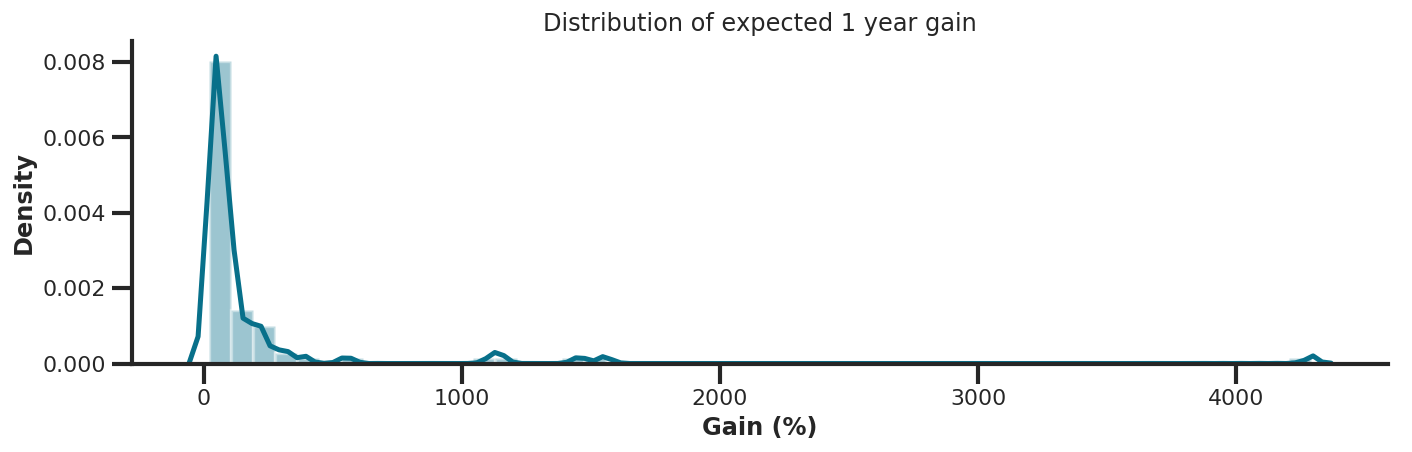

In [31]:
fig = figure(num=None, figsize=(12, 4), dpi=120, facecolor='w', edgecolor='k')

plt.subplot(1, 1, 1)
ax1 = sns.distplot(df_gains['gain'].dropna()*100, bins=50, color=greek_salad[2]);
#ax1.set_xlim(0, 400)
ax1.set_xlabel('Gain (%)', weight='bold')
ax1.set_ylabel('Density', weight = 'bold')
ax1.set_title('Distribution of expected 1 year gain')
sns.despine()
plt.tight_layout();

In [32]:
# ## Distribution of expected loss
# fig = figure(num=None, figsize=(12, 4), dpi=120, facecolor='w', edgecolor='k')

# plt.subplot(1, 1, 1)
# ax1 = sns.distplot(df_gains['loss'].dropna()*100, bins=50, color=greek_salad[3]);
# #ax1.set_xlim(0, 400)
# ax1.set_xlabel('Loss (%)', weight='bold')
# ax1.set_ylabel('Density', weight = 'bold')
# ax1.set_title('Distribution of expected 1 year loss')
# sns.despine()
# plt.tight_layout();

### These are the tickers that atleast show a higher growth trend and may outperform the market

In [33]:
df_selected_stocks = pd.merge(df_gains, nasdaq, how='inner', left_on='ticker', right_on='Symbol')
cols = ['ticker', 'gain', 'Name', 'MarketCap', 'Sector']

df_selected_stocks = df_selected_stocks[cols]
df_selected_stocks.to_csv('selected_stocks.csv', sep=',', encoding='utf-8')
df_selected_stocks.sample(5)

,ticker,gain,Name,MarketCap,Sector
60,PTCT,1.692048,"PTC Therapeutics, Inc.",1.737191e+09,Health Care
26,ERIC,0.489840,Ericsson,2.838163e+09,Technology
28,FEYE,0.320371,"FireEye, Inc.",3.303941e+09,Technology
25,ENDP,1.065279,Endo International plc,2.402732e+09,Health Care
56,PDD,1.218387,Pinduoduo Inc.,2.668595e+09,Miscellaneous


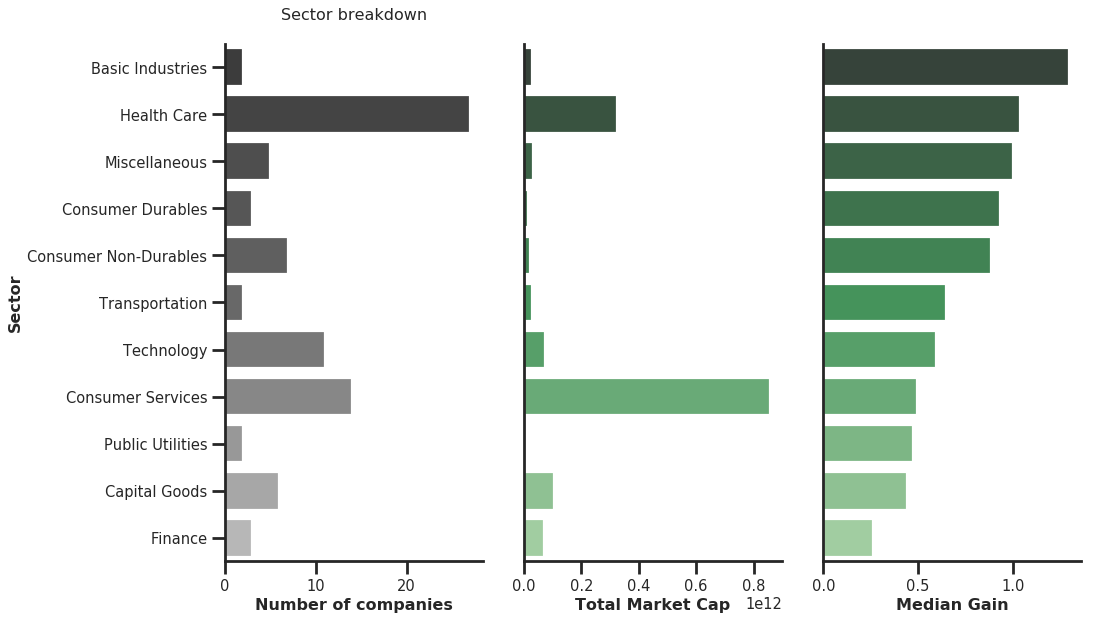

In [34]:
f = {'gain':['median'], 'MarketCap':['sum'], 'Name':['count']}

ratios = df_selected_stocks.groupby('Sector').agg(f)
ratios.columns = ratios.columns.get_level_values(0)
ratios = ratios.reset_index()
ratios = ratios.sort_values('gain', ascending=False)

fig = figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 3, 1)
ax1 = sns.barplot(x="Name", y="Sector", data=ratios, palette=("Greys_d"))
ax1.set_xlabel('Number of companies', weight='bold')
ax1.set_ylabel('Sector', weight = 'bold')
ax1.set_title('Sector breakdown\n')

plt.subplot(1, 3, 2)
ax2 = sns.barplot(x="MarketCap", y="Sector", data=ratios, palette=("Greens_d"))
ax2.set_xlabel('Total Market Cap', weight='bold')
ax2.set_ylabel('')
ax2.set_yticks([])

plt.subplot(1, 3, 3)
ax2 = sns.barplot(x="gain", y="Sector", data=ratios, palette=("Greens_d"))
ax2.set_xlabel('Median Gain', weight='bold')
ax2.set_ylabel('')
ax2.set_yticks([])

sns.despine()
plt.tight_layout();